Let's first visualize the downloaded DEM file

File Bounds: BoundingBox(left=446320.0, bottom=4238528.000032917, right=449477.0, top=4241739.000032917)
Coordinate System: EPSG:26917


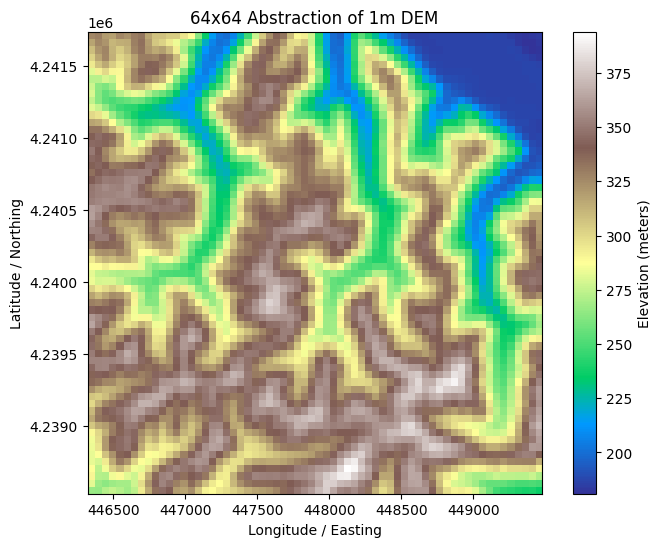

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to sys.path if it isn't there already
if project_root not in sys.path:
    sys.path.append(project_root)

import rasterio
import matplotlib.pyplot as plt
import numpy as np

from rasterio.enums import Resampling

def get_grid_from_local_dem(file_path, n_size):
    """
    Automatically detects bounds from a local 1m DEM and 
    resamples it to an N x N grid.
    """
    with rasterio.open(file_path) as dataset:
        # 1. Automatically get metadata/bounds
        bounds = dataset.bounds
        crs = dataset.crs
        print(f"File Bounds: {bounds}")
        print(f"Coordinate System: {crs}")

        # 2. Resample during read (Memory efficient)
        # We specify the output shape as (1, n_size, n_size) for (band, height, width)
        data = dataset.read(
            1,
            out_shape=(n_size, n_size),
            resampling=Resampling.bilinear # Or Resampling.max to preserve peaks
        )
        
        # 3. Handle NoData values (common in 1m DEMs)
        if dataset.nodata is not None:
            data = np.where(data == dataset.nodata, np.nan, data)

        return data, bounds

# --- Execution ---
# Replace with your West Virginia file path
dem_path = 'WV_DEM.tif' 
N = 64 

height_grid, dem_bounds = get_grid_from_local_dem(dem_path, N)

# Visualization
plt.figure(figsize=(8, 6))
plt.imshow(height_grid, cmap='terrain', extent=[dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top])
plt.colorbar(label='Elevation (meters)')
plt.title(f"{N}x{N} Abstraction of 1m DEM")
plt.xlabel("Longitude / Easting")
plt.ylabel("Latitude / Northing")
plt.show()

Let's now visualize the corresponding graph

In [2]:
from real_map_generation import RealTerrainGrid
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np  # For any distance calcs if needed

# Rotate clockwise 90 degrees to counteract the anticlockwise shift
corrected_height_grid = np.rot90(height_grid, k=-1)

graph_generator = RealTerrainGrid(corrected_height_grid, k_up=1.0, k_down=2.0)

graph_generator.compute_all_visibilities()
env_graph = graph_generator.get_graph().copy()

# Note that for some reason the x and y axes are flipped
graph_generator.add_obstacle(center=(40,56), rx=3, ry=5)
graph_generator.add_obstacle(center={34,42}, rx=4, ry=4)
graph_generator.add_obstacle(center=(55,33), rx=3, ry=5)
graph_generator.add_obstacle(center=(10,44), rx=4, ry=4)

blocked_env_graph = graph_generator.get_graph().copy()


/var/folders/sz/hz_r9sdd0978ddwt1zk8pj8m0000gn/T/ipykernel_12181/1801089494.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


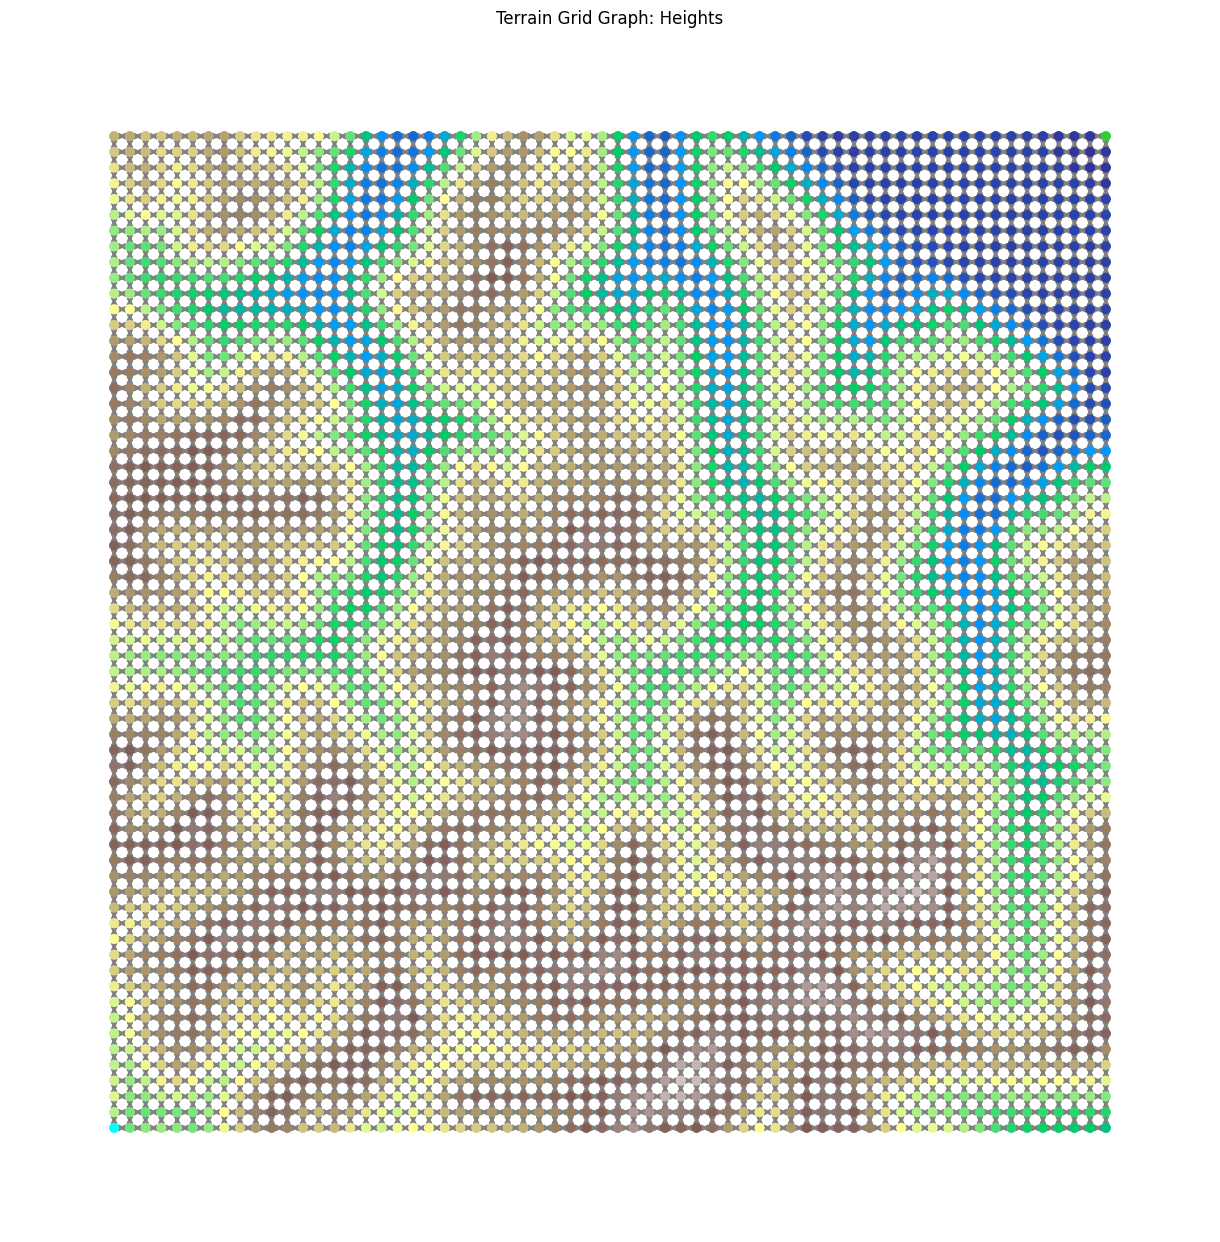

In [3]:

# --- 0. Select the Observer (your vision viewpoint) ---
observer_node = (35, 51) 

# Retrieve visible edges as sorted tuples for lookup
visible_set = []
# visible_set = set(tuple(sorted(e)) for e in env_graph.nodes[observer_node].get("visible_edges", []))

# 1. Setup Data for Plotting
pos = nx.get_node_attributes(env_graph, 'pos')
edge_labels = nx.get_edge_attributes(env_graph, 'distance')  # Or compute if missing
formatted_edge_labels = {k: f"{v:.1f}" for k, v in edge_labels.items()}

# 2. Setup Colormap for Heights
all_heights = [data.get('height', 0) for _, data in env_graph.nodes(data=True)]
max_height = max(all_heights) if all_heights else 1
norm = mcolors.Normalize(vmin=0, vmax=max_height + 1)
cmap = plt.cm.terrain

# 3. Build Node Color List
color_map = []
for node, data in env_graph.nodes(data=True):
    node_type = data.get("type", "intermediate")
    if node_type == "source":
        color_map.append("limegreen")  
    elif node_type == "target_unreached":
        color_map.append("cyan")     
    elif node_type == "obstacle":
        color_map.append("black")
    else:
        h = data.get('height', 0)
        rgba_color = cmap(norm(h))
        color_map.append(rgba_color)

# 4. Edge Colors (gold for visible from observer)
edge_color_map = []
for u, v in env_graph.edges():
    edge_key = tuple(sorted((u, v)))
    if edge_key in visible_set:
        edge_color_map.append('gold')
    else:
        edge_color_map.append('gray')

# 5. Draw the Graph
plt.figure(figsize=(12, 12))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map,
    with_labels=False,
    node_size=40,
    font_color='white',
    font_weight='bold',
    width=0.8,
    edge_color=edge_color_map
)

# Fixed: Pass the dict here
nx.draw_networkx_edge_labels(
    env_graph,
    pos,
    edge_labels=False,  
    font_size=8,
    label_pos=0.5
)

plt.title(f"Terrain Grid Graph: Heights")
plt.axis('off')
plt.tight_layout()
plt.show()

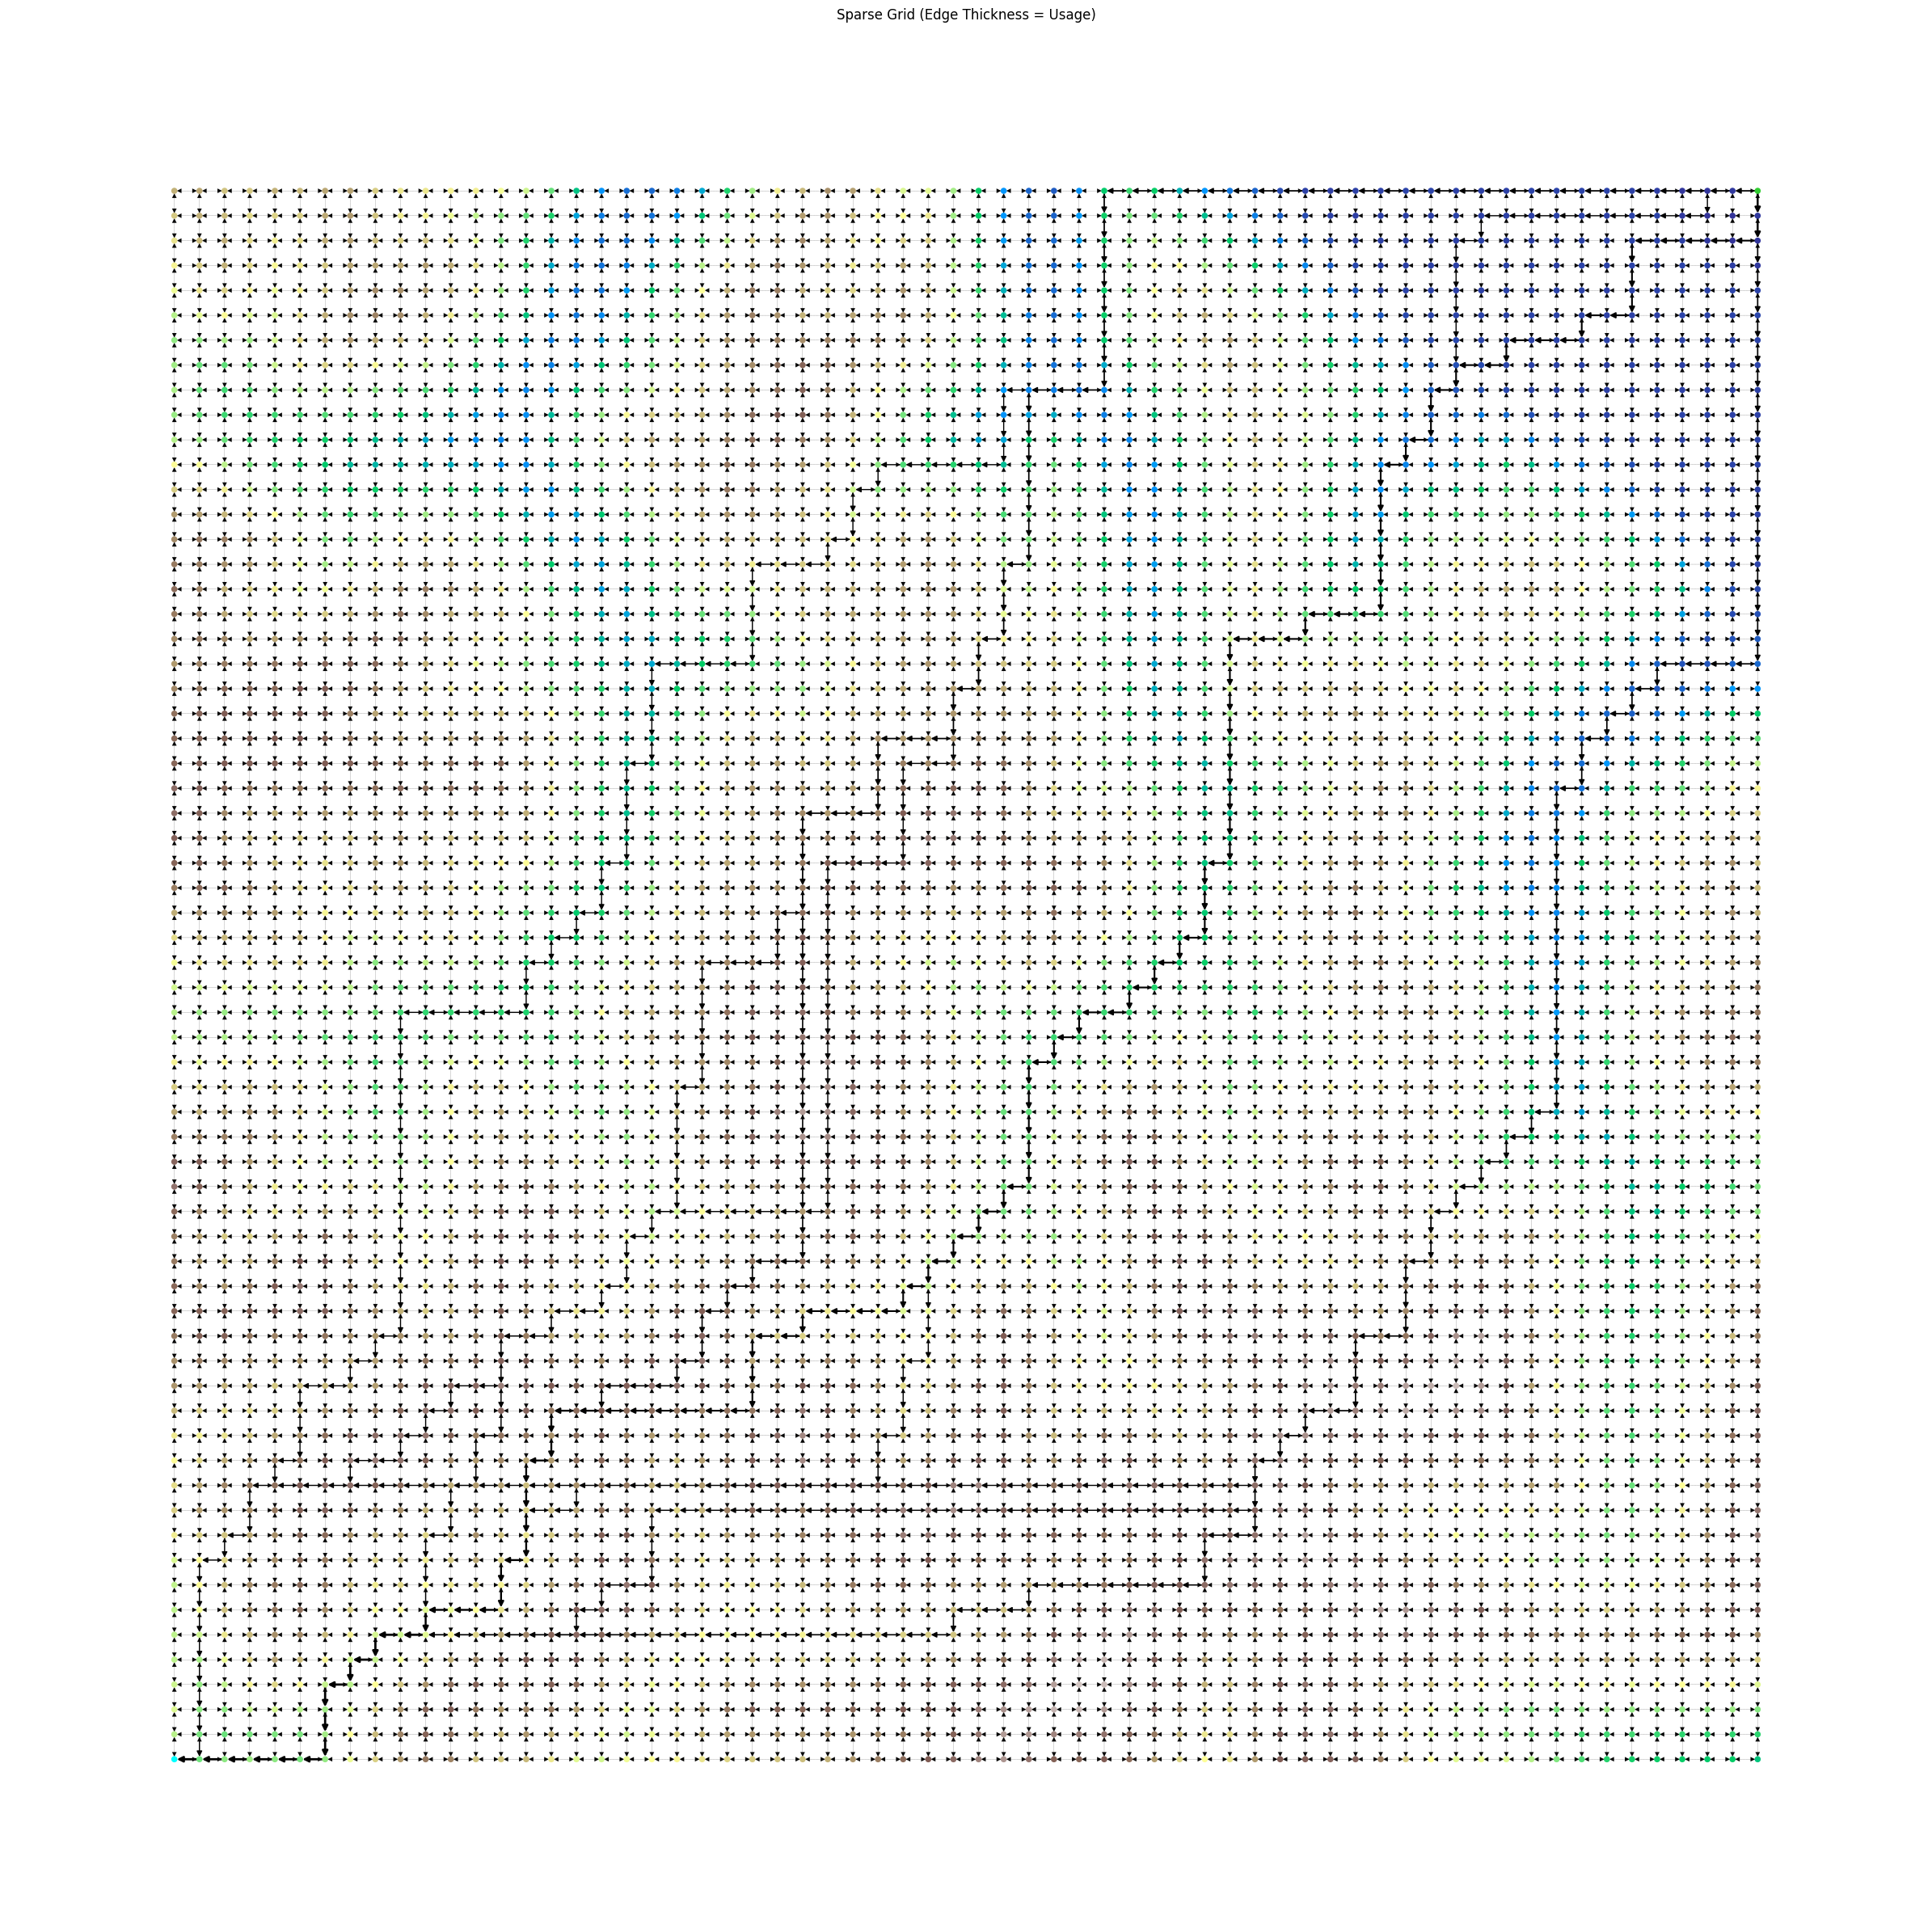

In [4]:
from Graph_Generation.target_graph import create_fully_connected_target_graph

target_graph = create_fully_connected_target_graph(env_graph, recursions=4, num_obstacles=3, obstacle_hop=4)

# --- 1. Prepare for Plotting ---

edge_labels = {}
for u, v, data in target_graph.edges(data=True):
    distance = data['distance']
    edge_labels[(u, v)] = f"{distance:.2f}"

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in env_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 2.0 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.1)

# --- Create the Single Plot (Sparse Grid) ---

# Set the figure size to 12x12
plt.figure(figsize=(24, 24))

# Set the title
plt.title("Sparse Grid (Edge Thickness = Usage)")

# Draw the Sparse Grid with the existing parameters
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map,
    with_labels=False,
    node_size=20,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Remove the obstacle edges entirely

In [5]:
# Remove all edges connected to obstacle nodes from the blocked_env_graph
edges_to_remove = [(u, v) for u, v in blocked_env_graph.edges() 
                   if blocked_env_graph.nodes[u].get('type') == 'obstacle' 
                   or blocked_env_graph.nodes[v].get('type') == 'obstacle']

blocked_env_graph.remove_edges_from(edges_to_remove)

# Update the visible_edges for all nodes to reflect the removed edges
for node in blocked_env_graph.nodes():
    if "visible_edges" in blocked_env_graph.nodes[node]:
        current_visible = blocked_env_graph.nodes[node]["visible_edges"]
        # Remove any blocked edges from the visible_edges set
        updated_visible = set(current_visible) - set(edges_to_remove)
        blocked_env_graph.nodes[node]["visible_edges"] = list(updated_visible)

Let's see what the shortest path agent intends to do

In [6]:
path_1 = nx.shortest_path(env_graph, source=(N-1,N-1), target=(0,0), weight="distance") # Start with the shortest path
target_nodes = [(N-1, N-1), (0,0)]
env_graph1 = env_graph.copy() # Agent's world model (doesn't know any edges are blocked)

current_node = path_1[0]
next_target_index = 1 # since 0 is the source
index = 0

while index < len(path_1) - 1:
    next_node = path_1[index + 1]

    # Update the next_target_index 
    if current_node == target_nodes[next_target_index]:
        next_target_index += 1
    
    # Check out all the observable edges
    observable_edges = set(blocked_env_graph.nodes[current_node]["visible_edges"]) # From the actual blocked env graph
    assumed_observable_edges = set(env_graph1.nodes[current_node]["visible_edges"]) # From the agent's world model 
    blocked_edges = assumed_observable_edges - observable_edges
    
    if len(blocked_edges) > 0:
        # Remove blocked edges from agent's world model
        for edge in blocked_edges:
            u, v = edge
            if env_graph1.has_edge(u, v):
                print(f"From {current_node}, observed edge ({u}, {v}) is blocked. Removing from graph.")
                env_graph1.remove_edge(u, v)
        # Update the visibility mapping as well
        for node in env_graph1.nodes():
            if "visible_edges" in env_graph1.nodes[node]:
                current_visible = env_graph1.nodes[node]["visible_edges"]
                # Remove any blocked edges from the visible_edges set
                updated_visible = set(current_visible) - blocked_edges
                env_graph1.nodes[node]["visible_edges"] = list(updated_visible)
        
        # Check if any blocked edge is in our current path
        path_edges = [(path_1[i], path_1[i+1]) for i in range(index, len(path_1) - 1)]

        # Create a set that includes both directions of blocked edges
        blocked_edges_both_directions = set()
        for u, v in blocked_edges:
            blocked_edges_both_directions.add((u, v))
            blocked_edges_both_directions.add((v, u))
        
        if any(edge in blocked_edges_both_directions for edge in path_edges):
            print(f"Blocked edge detected in planned path. Recalculating entire remaining path...")
            
            # Replan through ALL remaining targets
            remaining_targets = target_nodes[next_target_index:]
            new_path = [current_node]
            
            for target in remaining_targets:
                segment = nx.shortest_path(env_graph1, source=new_path[-1], target=target, weight="distance")
                new_path.extend(segment[1:])  # Append segment excluding the first node (already in new_path)
            
            # Replace the rest of path_1 with the new path
            path_1 = path_1[:index + 1] + new_path[1:]

    # Get the next node from the (possibly updated) path
    next_node = path_1[index + 1]
    
    # Now that we have a traversable path, just go to the next node in path
    print(f"Moving from {current_node} to {next_node}")
    current_node = next_node
    index += 1


Moving from (63, 63) to (63, 62)
Moving from (63, 62) to (63, 61)
Moving from (63, 61) to (63, 60)
Moving from (63, 60) to (63, 59)
Moving from (63, 59) to (63, 58)
Moving from (63, 58) to (63, 57)
Moving from (63, 57) to (63, 56)
Moving from (63, 56) to (63, 55)
Moving from (63, 55) to (63, 54)
Moving from (63, 54) to (63, 53)
Moving from (63, 53) to (63, 52)
Moving from (63, 52) to (63, 51)
Moving from (63, 51) to (63, 50)
Moving from (63, 50) to (63, 49)
Moving from (63, 49) to (63, 48)
Moving from (63, 48) to (63, 47)
Moving from (63, 47) to (63, 46)
Moving from (63, 46) to (63, 45)
Moving from (63, 45) to (62, 45)
Moving from (62, 45) to (62, 44)
Moving from (62, 44) to (61, 44)
Moving from (61, 44) to (60, 44)
Moving from (60, 44) to (59, 44)
From (59, 44), observed edge ((59, 42), (60, 42)) is blocked. Removing from graph.
From (59, 44), observed edge ((60, 42), (59, 42)) is blocked. Removing from graph.
From (59, 44), observed edge ((59, 43), (59, 42)) is blocked. Removing from

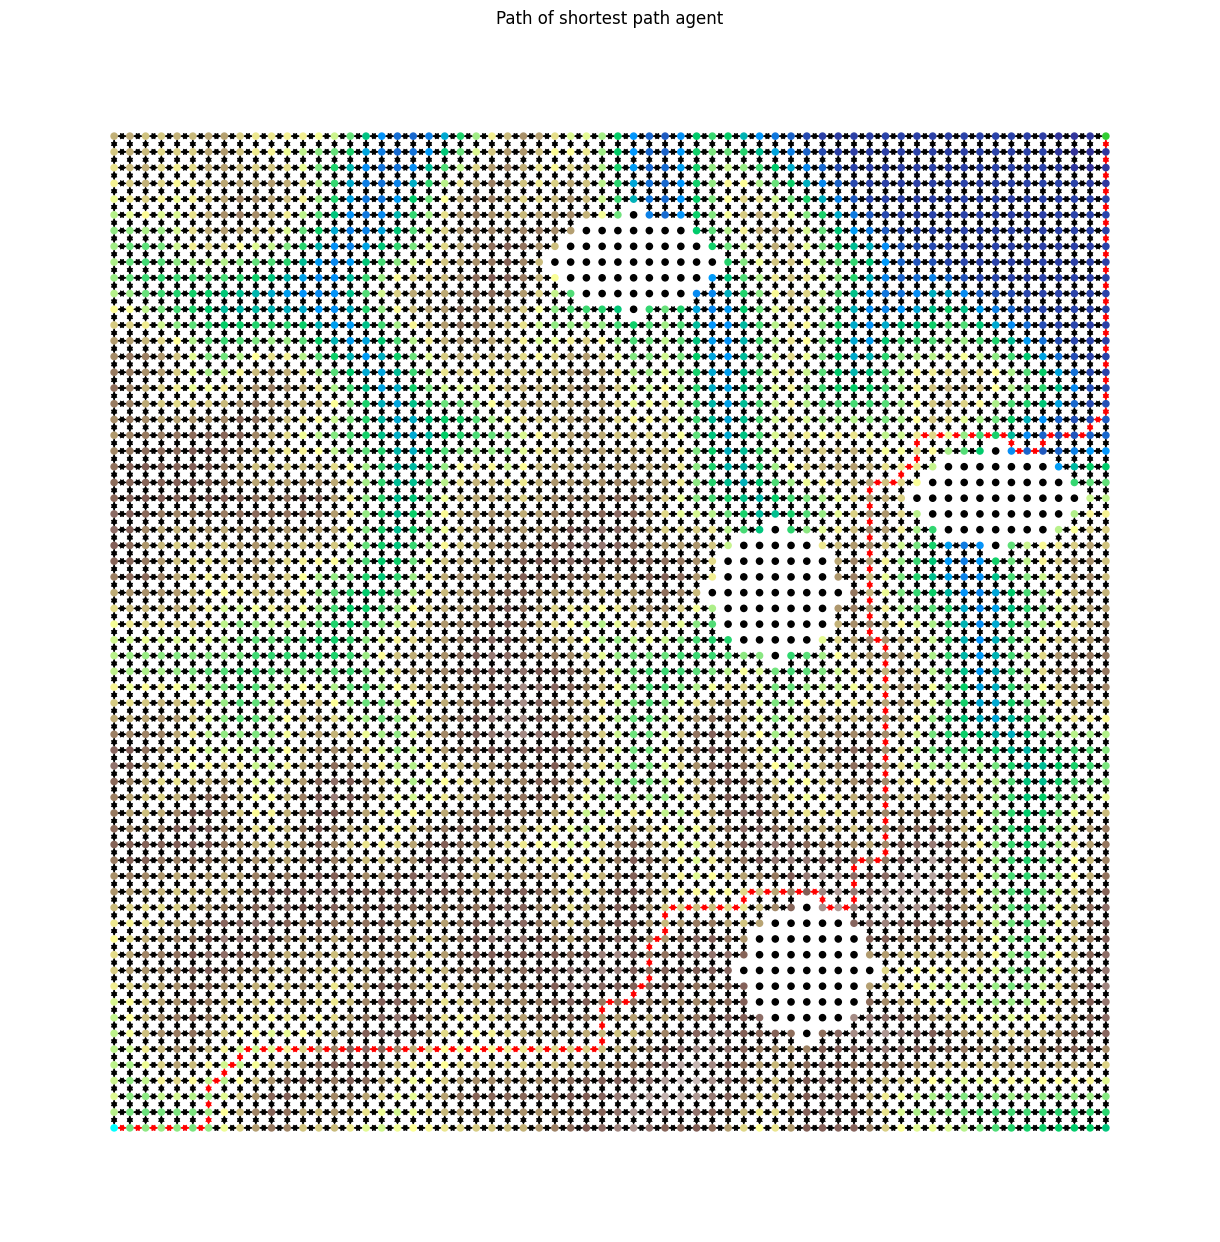

Total path length taken by the agent: 138.18


In [ ]:
path_1_edges = {tuple(sorted((path_1[i], path_1[i+1]))) 
                   for i in range(len(path_1) - 1)}

path1_edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_1_edges:
        path1_edge_color.append('red')
    else:
        # Style for unblocked edges: black
        path1_edge_color.append('black')

blocked_color_map = []
for node, data in blocked_env_graph.nodes(data=True):
    node_type = data.get("type", "intermediate")
    if node_type == "source":
        blocked_color_map.append("limegreen")  
    elif node_type == "target_unreached":
        blocked_color_map.append("cyan")     
    elif node_type == "obstacle":
        blocked_color_map.append("black")
    else:
        h = data.get('height', 0)
        rgba_color = cmap(norm(h))
        blocked_color_map.append(rgba_color)

# Draw the graph with updated styles
plt.figure(figsize=(12, 12))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=blocked_color_map, 
    with_labels=False,
    node_size=20,
    width=0.5,
    edge_color=path1_edge_color
)

plt.title("Path of shortest path agent")
plt.show()

total_path_length = 0.0
for i in range(len(path_1) - 1):
    u = path_1[i]
    v = path_1[i + 1]
    edge_data = blocked_env_graph.get_edge_data(u, v)
    if edge_data:
        total_path_length += edge_data.get('distance', 0.0)
print(f"Total path length taken by the agent: {total_path_length:.2f}")

Let's now see what our agent intends to do

In [15]:
from Single_Agent.repeated_topk import RepeatedTopK

env_graph2 = env_graph.copy()
path2_generator = RepeatedTopK(reward_ratio = 1.0, env_graph=env_graph2, target_graph=target_graph)
path_2 = path2_generator.find_best_path() # Start with the best path
target_nodes = [(N-1, N-1), (0,0)]

current_node = path_2[0]
next_target_index = 1 # since 0 is the source
index = 0

while index < len(path_2) - 1:
    next_node = path_2[index + 1]

    # Update the next_target_index 
    if current_node == target_nodes[next_target_index]:
        next_target_index += 1
    
    # Check out all the observable edges
    observable_edges = set(blocked_env_graph.nodes[current_node]["visible_edges"]) # From the actual blocked env graph
    assumed_observable_edges = set(env_graph2.nodes[current_node]["visible_edges"]) # From the agent's world model 
    blocked_edges = assumed_observable_edges - observable_edges
    
    if len(blocked_edges) > 0:
        # Remove blocked edges from agent's world model
        for edge in blocked_edges:
            u, v = edge
            if env_graph2.has_edge(u, v):
                print(f"From {current_node}, observed edge ({u}, {v}) is blocked. Removing from graph.")
                env_graph2.remove_edge(u, v)
        
        # Update the visibility mapping as well
        for node in env_graph2.nodes():
            if "visible_edges" in env_graph2.nodes[node]:
                current_visible = env_graph2.nodes[node]["visible_edges"]
                # Remove any blocked edges from the visible_edges set
                updated_visible = set(current_visible) - blocked_edges
                env_graph2.nodes[node]["visible_edges"] = list(updated_visible)
        
        # Check if any blocked edge is in our current path
        path_edges = [(path_2[i], path_2[i+1]) for i in range(index, len(path_2) - 1)]

        # Create a set that includes both directions of blocked edges
        blocked_edges_both_directions = set()
        for u, v in blocked_edges:
            blocked_edges_both_directions.add((u, v))
            blocked_edges_both_directions.add((v, u))

        if any(edge in blocked_edges_both_directions for edge in path_edges):
            print(f"Blocked edge detected in planned path. Recalculating entire remaining path...")
            
            # Replan through ALL remaining targets
            remaining_targets = target_nodes[next_target_index:]
            new_path = [current_node]
            
            for target in remaining_targets:
                segment = path2_generator.alternate_path_online(new_path[-1], target)
                new_path.extend(segment[1:])  # Append segment excluding the first node (already in new_path)
            
            # Replace the rest of path_1 with the new path
            path_2 = path_2[:index + 1] + new_path[1:]

    # Get the next node from the (possibly updated) path
    next_node = path_2[index + 1]
    
    # Now that we have a traversable path, just go to the next node in path
    print(f"Moving from {current_node} to {next_node}")
    current_node = next_node
    index += 1

Moving from (63, 63) to (62, 63)
Moving from (62, 63) to (61, 63)
Moving from (61, 63) to (60, 63)
Moving from (60, 63) to (59, 63)
Moving from (59, 63) to (58, 63)
Moving from (58, 63) to (57, 63)
Moving from (57, 63) to (56, 63)
Moving from (56, 63) to (55, 63)
Moving from (55, 63) to (54, 63)
Moving from (54, 63) to (53, 63)
Moving from (53, 63) to (52, 63)
Moving from (52, 63) to (51, 63)
Moving from (51, 63) to (50, 63)
Moving from (50, 63) to (49, 63)
Moving from (49, 63) to (48, 63)
Moving from (48, 63) to (47, 63)
Moving from (47, 63) to (46, 63)
Moving from (46, 63) to (45, 63)
Moving from (45, 63) to (44, 63)
Moving from (44, 63) to (43, 63)
Moving from (43, 63) to (42, 63)
Moving from (42, 63) to (41, 63)
Moving from (41, 63) to (40, 63)
Moving from (40, 63) to (39, 63)
Moving from (39, 63) to (38, 63)
From (38, 63), observed edge ((30, 53), (30, 52)) is blocked. Removing from graph.
From (38, 63), observed edge ((33, 58), (33, 59)) is blocked. Removing from graph.
From (38,

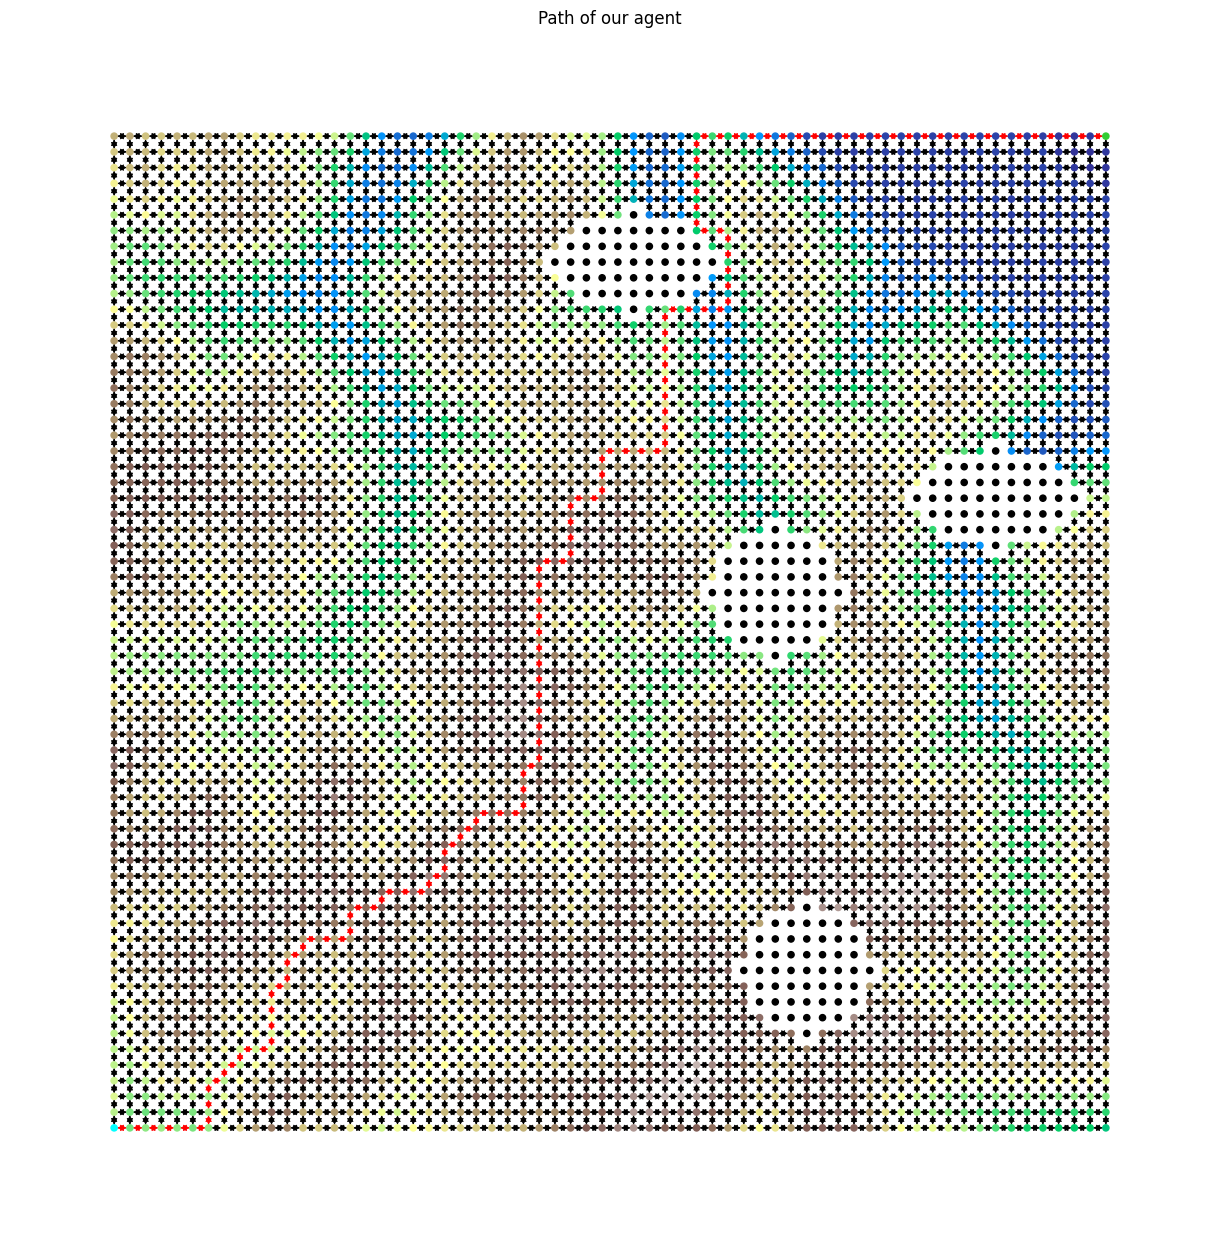

Total path length taken by the agent: 135.55


In [16]:
path_2_edges = {tuple(sorted((path_2[i], path_2[i+1]))) 
                   for i in range(len(path_2) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(blocked_env_graph, 'pos')

path2_edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_2_edges:
        path2_edge_color.append('red')
    else:
        # Style for unblocked edges: black
        path2_edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(12, 12))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=blocked_color_map, 
    with_labels=False,
    node_size=20,
    width=0.5,
    edge_color=path2_edge_color
)

plt.title("Path of our agent")
plt.show()

total_path_length = 0.0
for i in range(len(path_2) - 1):
    u = path_2[i]
    v = path_2[i + 1]
    edge_data = blocked_env_graph.get_edge_data(u, v)
    if edge_data:
        total_path_length += edge_data.get('distance', 0.0)
print(f"Total path length taken by the agent: {total_path_length:.2f}")

Let's also create an interactive version of the map

In [4]:
import plotly.graph_objects as go

def plot_interactive_env_graph(env_graph, observer_node=None):
    # 1. Prepare Positions and Visibility
    pos = nx.get_node_attributes(env_graph, 'pos')
    
    # Standardize visible edges for lookup
    visible_set = set()
    if observer_node and "visible_edges" in env_graph.nodes[observer_node]:
        visible_set = set(tuple(sorted(e)) for e in env_graph.nodes[observer_node]["visible_edges"])

    # 2. Build Edge Traces (Gray for hidden, Gold for visible)
    # We split them into two traces so they can be toggled in the legend
    edge_x_hidden, edge_y_hidden = [], []
    edge_x_visible, edge_y_visible = [], []

    for u, v in env_graph.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_key = tuple(sorted((u, v)))
        
        if edge_key in visible_set:
            edge_x_visible.extend([x0, x1, None])
            edge_y_visible.extend([y0, y1, None])
        else:
            edge_x_hidden.extend([x0, x1, None])
            edge_y_hidden.extend([y0, y1, None])

    # 3. Build Node Traces
    node_x, node_y = [], []
    node_color, node_text, node_size = [], [], []

    for node, data in env_graph.nodes(data=True):
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Metadata for Hover
        h = data.get('height', 0)
        dist_info = "" # You could add sum of edge weights here
        node_text.append(f"Node: {node}<br>Height: {h:.2f}<br>Type: {data.get('type')}")

        # Color Logic
        if data.get("type") == "source":
            node_color.append('limegreen')
            node_size.append(15)
        elif data.get("type") == "target":
            node_color.append('cyan')
            node_size.append(15)
        else:
            # Using Plotly's internal terrain-like colorscale (Earth)
            node_color.append(h) 
            node_size.append(8)

    # 4. Create the Figure
    fig = go.Figure()

    # Add Hidden Edges
    fig.add_trace(go.Scatter(
        x=edge_x_hidden, y=edge_y_hidden,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none', mode='lines', name='Hidden Edges'
    ))

    # Add Visible Edges (Gold)
    fig.add_trace(go.Scatter(
        x=edge_x_visible, y=edge_y_visible,
        line=dict(width=2, color='gold'),
        hoverinfo='none', mode='lines', name='Visible from Observer'
    ))

    # Add Nodes
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        name='Terrain Nodes',
        marker=dict(
            showscale=True,
            colorscale='Earth',
            color=node_color,
            size=node_size,
            colorbar=dict(title='Height', thickness=15, x=1.02),
            line_width=1
        ),
        text=node_text,
        hoverinfo='text'
    ))

    # Layout tweaks
    fig.update_layout(
        title=f"Interactive Terrain Graph",
        showlegend=True,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white'
    )

    return fig

# --- Execution ---
fig = plot_interactive_env_graph(env_graph)
fig.show(renderer="browser")